In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

# Calculating derivatives in Python

In [9]:
from sympy import *

u,v,alpha = symbols('u v alpha')
expr = (u**(-alpha) + v**(-alpha) - 1)**(-1/alpha)

In [10]:
expr

(-1 + v**(-alpha) + u**(-alpha))**(-1/alpha)

In [11]:
diff(expr, u)

1/(u*u**alpha*(-1 + v**(-alpha) + u**(-alpha))*(-1 + v**(-alpha) + u**(-alpha))**(1/alpha))

# Archimedean copulas

## Clayton

### Sampling

#### method 1

/tmp/ipykernel_62169/2599343230.py:16: RuntimeWarning: divide by zero encountered in power
  z = ((pairs[:,0].reshape([100,100]))**(-alpha) + (pairs[:,1].reshape([100,100]))**(-alpha))**(-1/alpha)
/tmp/ipykernel_62169/2599343230.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img)


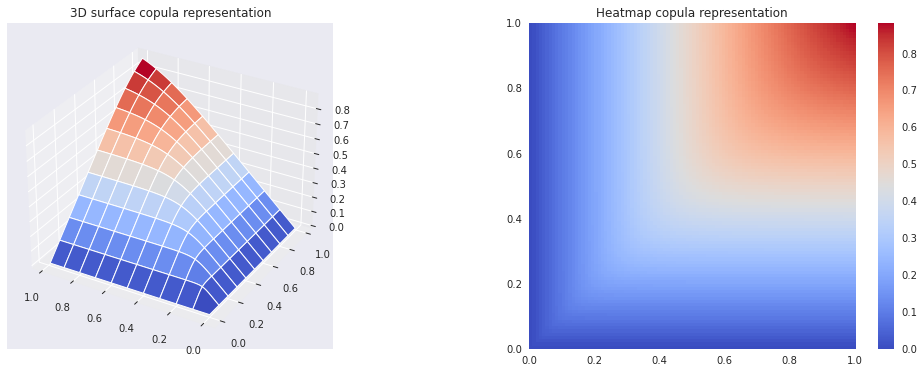

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(18,6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122)

x = np.arange(0,1,0.01)
y = np.arange(0,1,0.01)
x,y = np.meshgrid(x,y)

alpha = 6
# apply inverse CDF to each point on a grid
pairs = np.array([[i, j] for (i,j) in zip(x.flatten(),y.flatten())])
# calculate the product of two CDFs for each point on a grid
z = ((pairs[:,0].reshape([100,100]))**(-alpha) + (pairs[:,1].reshape([100,100]))**(-alpha))**(-1/alpha)

ax0.plot_surface(x, y, z, cmap=cm.coolwarm, rstride=10, cstride=10, linewidth=1)
ax0.invert_yaxis()
ax0.set(title='3D surface copula representation')
img = ax1.imshow(np.flip(z,axis=0), cmap=cm.coolwarm, extent=[0,1,0,1])
ax1.grid(False)
ax1.set(title='Heatmap copula representation')
fig.colorbar(img)

In [13]:
# set parameter
alpha = 6
# generate a sample
u = np.random.rand(10000)
t = np.random.rand(10000)
v = ((t / u**(-alpha-1))**(-alpha/(1+alpha)) - u**(-alpha) + 1)**(-1/alpha)

[Text(0.5, 1.0, 'Scatterplot of U, V'), Text(0.5, 0, 'U'), Text(0, 0.5, 'V')]

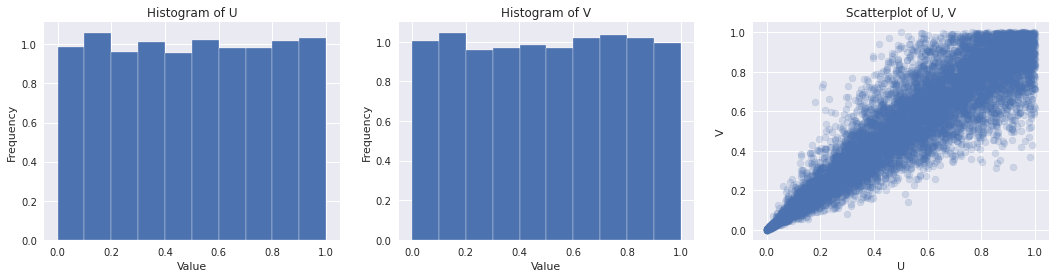

In [14]:
# plot marginals and joint distribution
fig, ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
ax[0].hist(u, density=True)
ax[0].set(title='Histogram of U', xlabel='Value', ylabel='Frequency')
ax[1].hist(v, density=True)
ax[1].set(title='Histogram of V', xlabel='Value', ylabel='Frequency')
ax[2].scatter(u, v, alpha=0.2)
ax[2].set(title='Scatterplot of U, V', xlabel='U', ylabel='V')

#### method 2

In [15]:
from scipy.optimize import brentq

In [16]:
def clayton_phi(t, alpha):
    return 1/alpha * (t**(-alpha) - 1)

def clayton_phi_inv(t, alpha):
    return (alpha * t + 1)**(-1/alpha)

def clayton_phi_prime(t, alpha):
    return (-t)**(-alpha-1)

def clayton_K(t, alpha):
    return t - clayton_phi(t, alpha) / clayton_phi_prime(t, alpha)

In [17]:
# set copula parameter
alpha = 6

# step 1
t1 = np.random.rand(10000)
t2 = np.random.rand(10000)

# steps 2 and 3
w = []
for t in t2:
    func = lambda w: clayton_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))
w = np.array(w).flatten()

# step 4
u = clayton_phi_inv(t1 * clayton_phi(w, alpha=alpha), alpha=alpha)
v = clayton_phi_inv((1-t1) * clayton_phi(w, alpha=alpha), alpha=alpha)

[Text(0.5, 1.0, 'Scatterplot of U, V'), Text(0.5, 0, 'U'), Text(0, 0.5, 'V')]

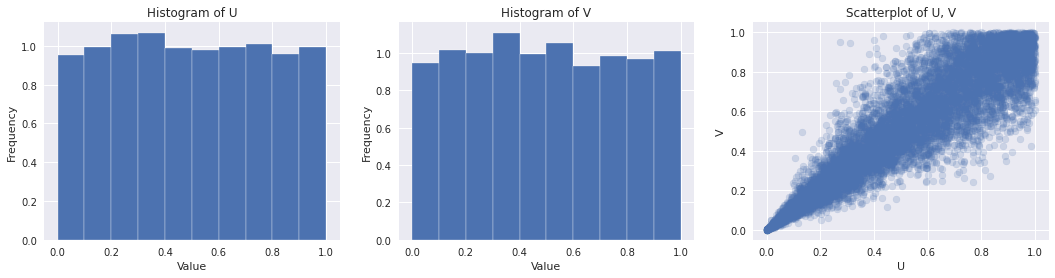

In [18]:
# plot marginals and joint distribution
fig, ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
ax[0].hist(u, density=True)
ax[0].set(title='Histogram of U', xlabel='Value', ylabel='Frequency')
ax[1].hist(v, density=True)
ax[1].set(title='Histogram of V', xlabel='Value', ylabel='Frequency')
ax[2].scatter(u, v, alpha=0.2)
ax[2].set(title='Scatterplot of U, V', xlabel='U', ylabel='V')

### Fitting

#### method 1

In [19]:
# define distributions
dist_x = stats.norm()
dist_y = stats.expon()
# transform
x = dist_x.ppf(u)
y = dist_y.ppf(v)
# calculate tau
tau = stats.kendalltau(x,y)[0]
# calculate alpha
clayton_alpha = 2 * tau / (1 - tau)
clayton_alpha

6.045806460334388

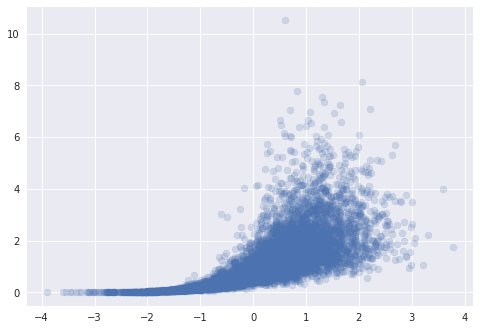

In [20]:
# plot
plt.scatter(x,y, alpha=0.2)

#### method 2

In [21]:
from sympy import *

# define variables
u1,u2,alpha = symbols('u1 u2 alpha')
# define function
expr = (u1**(-alpha) + u2**(-alpha) - 1)**(-1/alpha)
# differentiate
diff(expr, u1, u2)

(alpha + 1)/(u1*u1**alpha*u2*u2**alpha*(-1 + u2**(-alpha) + u1**(-alpha))**2*(-1 + u2**(-alpha) + u1**(-alpha))**(1/alpha))

In [22]:
from scipy.optimize import minimize_scalar

In [23]:
def clayton_pdf(u1, u2, alpha):
    num = u1**(-alpha) * u2**(-alpha) * (alpha+1) * (-1 + u2**(-alpha) + u1**(-alpha))**(-1/alpha)
    denom = u1 * u2 * (-1 + u2**(-alpha) + u1**(-alpha))**2
    return num/denom

In [24]:
def clayton_neg_likelihood(alpha, u1, u2):
    return -np.sum(np.log(clayton_pdf(u1,u2,alpha)))

In [25]:
minimize_scalar(clayton_neg_likelihood, args=(dist_x.cdf(x), dist_y.cdf(y)), 
         bounds=(-1,20), method='bounded')

     fun: -10879.032365604711
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 6.046682138781914

## Gumbel

### Sampling

In [27]:
def gumbel_phi(t, alpha):
    return (-np.log(t))**alpha

def gumbel_phi_inv(t, alpha):
    return np.exp(-t**(1/alpha))

def gumbel_phi_prime(t, alpha):
    return -alpha/t * (-np.log(t))**(alpha-1)

def gumbel_K(t, alpha):
    return t - gumbel_phi(t, alpha) / gumbel_phi_prime(t, alpha)

In [28]:
alpha = 5.6
t1 = np.random.rand(10000)
t2 = np.random.rand(10000)

In [29]:
w = []
for t in t2:
    func = lambda w: gumbel_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))
w = np.array(w).flatten()

In [30]:
u = gumbel_phi_inv(t1 * gumbel_phi(w, alpha=alpha), alpha=alpha)
v = gumbel_phi_inv((1-t1) * gumbel_phi(w, alpha=alpha), alpha=alpha)

[Text(0.5, 1.0, 'Scatterplot of U, V'), Text(0.5, 0, 'U'), Text(0, 0.5, 'V')]

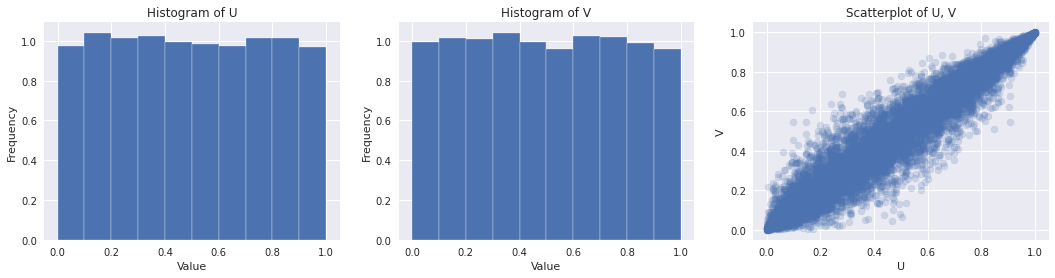

In [31]:
# plot marginals and joint distribution
fig, ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
ax[0].hist(u, density=True)
ax[0].set(title='Histogram of U', xlabel='Value', ylabel='Frequency')
ax[1].hist(v, density=True)
ax[1].set(title='Histogram of V', xlabel='Value', ylabel='Frequency')
ax[2].scatter(u, v, alpha=0.2)
ax[2].set(title='Scatterplot of U, V', xlabel='U', ylabel='V')

### Fitting

#### method 1

In [32]:
# define distributions
dist_x = stats.norm()
dist_y = stats.expon()
# transform
x = dist_x.ppf(u)
y = dist_y.ppf(v)
# calculate tau
tau = stats.kendalltau(x,y)[0]
# calculate alpha
gumbel_alpha = 1 / (1 - tau)
gumbel_alpha

5.579714415049057

#### method 2

In [61]:
from sympy import *

# define variables
u1,u2,alpha = symbols('u1 u2 alpha')
# define function
expr = exp(-((-log(u1))**alpha + (-log(u2))**alpha)**(1/alpha))
# differentiate
diff(expr, u1, u2)

(-log(u1))**alpha*(-log(u2))**alpha*((-log(u1))**alpha + (-log(u2))**alpha)**(1/alpha)*(alpha + ((-log(u1))**alpha + (-log(u2))**alpha)**(1/alpha) - 1)*exp(-((-log(u1))**alpha + (-log(u2))**alpha)**(1/alpha))/(u1*u2*((-log(u1))**alpha + (-log(u2))**alpha)**2*log(u1)*log(u2))

In [62]:
def gumbel_pdf(u1, u2, alpha):
    num1 = (-np.log(u1))**alpha * (-np.log(u2))**alpha * ((-np.log(u1))**alpha + (-np.log(u2))**alpha)**(1/alpha)
    num2 = alpha + ((-np.log(u1))**alpha + (-np.log(u2))**alpha)**(1/alpha) - 1
    num3 = np.exp(-((-np.log(u1))**alpha + (-np.log(u2))**alpha)**(1/alpha))
    denom = u1 * u2 * ((-np.log(u1))**alpha + (-np.log(u2))**alpha)**2 * np.log(u1) * np.log(u2)
    
    return (num1 * num2 * num3) / denom

In [63]:
def gumbel_neg_likelihood(alpha, u1, u2):
    return -np.sum(np.log(gumbel_pdf(u1,u2,alpha)))

In [64]:
minimize_scalar(gumbel_neg_likelihood, args=(dist_x.cdf(x), dist_y.cdf(y)), 
         bounds=(-1,20), method='bounded')

     fun: -13036.11348750942
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 5.556972803328864

## Frank

### Sampling

In [33]:
def frank_phi(t, alpha):
    return -np.log((np.exp(-alpha*t) - 1) / (np.exp(-alpha) - 1))

def frank_phi_inv(t, alpha):
    return -1/alpha * np.log((np.exp(-alpha) - 1) / np.exp(t) + 1)

def frank_phi_prime(t, alpha):
    return alpha * np.exp(-alpha*t) / (np.exp(-alpha*t) - 1)

def frank_K(t, alpha):
    return t - frank_phi(t, alpha) / frank_phi_prime(t, alpha)

In [34]:
alpha = 8
t1 = np.random.rand(10000)
t2 = np.random.rand(10000)

In [35]:
w = []
for t in t2:
    func = lambda w: frank_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))
w = np.array(w).flatten()

In [36]:
u = frank_phi_inv(t1 * frank_phi(w, alpha=alpha), alpha=alpha)
v = frank_phi_inv((1-t1) * frank_phi(w, alpha=alpha), alpha=alpha)

[Text(0.5, 1.0, 'Scatterplot of U, V'), Text(0.5, 0, 'U'), Text(0, 0.5, 'V')]

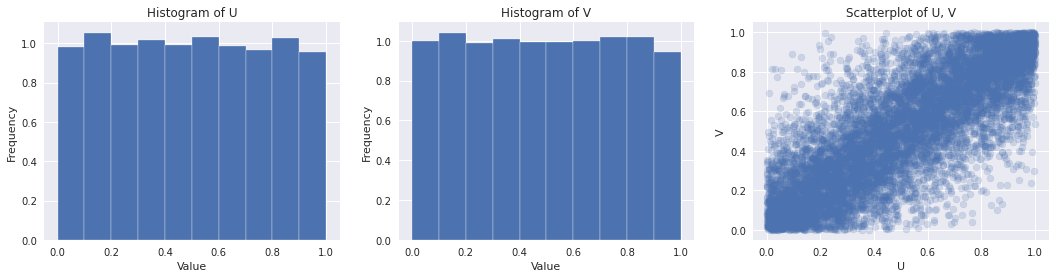

In [37]:
# plot marginals and joint distribution
fig, ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
ax[0].hist(u, density=True)
ax[0].set(title='Histogram of U', xlabel='Value', ylabel='Frequency')
ax[1].hist(v, density=True)
ax[1].set(title='Histogram of V', xlabel='Value', ylabel='Frequency')
ax[2].scatter(u, v, alpha=0.2)
ax[2].set(title='Scatterplot of U, V', xlabel='U', ylabel='V')

### Fitting

In [38]:
# define variables
u1,u2,alpha = symbols('u1 u2 alpha')
# define function
expr = -1/alpha * log(1 + (exp(-alpha*u1)-1) * (exp(-alpha*u2)-1) / (exp(-alpha) - 1))
# differentiate
diff(expr, u1, u2)

alpha*(1 + (1 - exp(-alpha*u1))*(1 - exp(-alpha*u2))/((1 - (1 - exp(-alpha*u1))*(1 - exp(-alpha*u2))/(1 - exp(-alpha)))*(1 - exp(-alpha))))*exp(-alpha*u1)*exp(-alpha*u2)/((1 - (1 - exp(-alpha*u1))*(1 - exp(-alpha*u2))/(1 - exp(-alpha)))*(1 - exp(-alpha)))

In [39]:
simplify(diff(expr, u1, u2))

alpha*(exp(alpha) - 1)*exp(alpha*(u1 + u2 + 1))/(-(exp(alpha) - 1)*exp(alpha*(u1 + u2)) + (exp(alpha*u1) - 1)*(exp(alpha*u2) - 1)*exp(alpha))**2

In [40]:
def frank_pdf(u1, u2, alpha):
    num = alpha * (np.exp(alpha) - 1) * np.exp(alpha * (u1 + u2 + 1))
    denom = (-(np.exp(alpha) - 1) * np.exp(alpha * (u1 + u2)) + 
             (np.exp(alpha*u1)-1) * (np.exp(alpha*u2)-1) * np.exp(alpha))**2
    return num/denom

In [41]:
def frank_neg_likelihood(alpha, u1, u2):
    return -np.sum(np.log(frank_pdf(u1,u2,alpha)))

In [42]:
# define distributions
dist_x = stats.norm()
dist_y = stats.expon()
# transform
x = dist_x.ppf(u)
y = dist_y.ppf(v)

In [43]:
minimize_scalar(frank_neg_likelihood, args=(dist_x.cdf(x), dist_y.cdf(y)), 
         bounds=(-20,20), method='bounded')

     fun: -4821.729940885223
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 7.945035295094674

## Joe

### Sampling

In [44]:
def joe_phi(t, alpha):
    return -np.log(1 - (1-t)**alpha)

def joe_phi_inv(t, alpha):
    return 1 - (1 - np.exp(-t))**(1/alpha)

def joe_phi_prime(t, alpha):
    return -alpha * (1-t)**(alpha-1) / (1 - (1-t)**alpha)

def joe_K(t, alpha):
    return t - joe_phi(t, alpha) / joe_phi_prime(t, alpha)

In [45]:
alpha = 5
t1 = np.random.rand(10000)
t2 = np.random.rand(10000)

In [46]:
w = []
for t in t2:
    func = lambda w: joe_K(w, alpha=alpha) - t
    w.append(brentq(func, 0.0000000001, 0.9999999999))   
w = np.array(w).flatten()

In [47]:
u = joe_phi_inv(t1 * joe_phi(w, alpha=alpha), alpha=alpha)
v = joe_phi_inv((1-t1) * joe_phi(w, alpha=alpha), alpha=alpha)

[Text(0.5, 1.0, 'Scatterplot of U, V'), Text(0.5, 0, 'U'), Text(0, 0.5, 'V')]

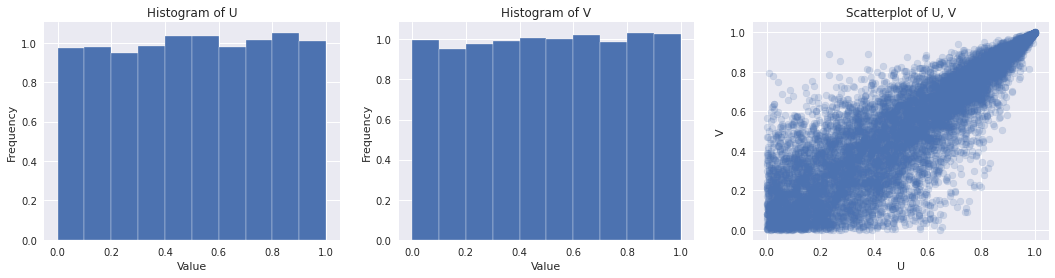

In [48]:
# plot marginals and joint distribution
fig, ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
ax[0].hist(u, density=True)
ax[0].set(title='Histogram of U', xlabel='Value', ylabel='Frequency')
ax[1].hist(v, density=True)
ax[1].set(title='Histogram of V', xlabel='Value', ylabel='Frequency')
ax[2].scatter(u, v, alpha=0.2)
ax[2].set(title='Scatterplot of U, V', xlabel='U', ylabel='V')

### Fitting

In [49]:
# define variables
u1,u2,alpha = symbols('u1 u2 alpha')
# define function
expr = 1 - ((1-u1)**alpha + (1-u2)**alpha - (1-u1)**alpha * (1-u2)**alpha)**(1/alpha)
# differentiate
diff(expr, u1, u2)

(1 - u1)**alpha*(1 - u2)**alpha*(-(1 - u1)**alpha*(1 - u2)**alpha + (1 - u1)**alpha + (1 - u2)**alpha)**(1/alpha)*(alpha*((1 - u1)**alpha - 1)*((1 - u2)**alpha - 1)/(-(1 - u1)**alpha*(1 - u2)**alpha + (1 - u1)**alpha + (1 - u2)**alpha) + alpha - ((1 - u1)**alpha - 1)*((1 - u2)**alpha - 1)/(-(1 - u1)**alpha*(1 - u2)**alpha + (1 - u1)**alpha + (1 - u2)**alpha))/((u1 - 1)*(u2 - 1)*(-(1 - u1)**alpha*(1 - u2)**alpha + (1 - u1)**alpha + (1 - u2)**alpha))

In [50]:
simplify(diff(expr, u1, u2))

(1 - u1)**(alpha - 1)*(1 - u2)**(alpha - 1)*(-(1 - u1)**alpha*(1 - u2)**alpha + (1 - u1)**alpha + (1 - u2)**alpha)**(-2 + 1/alpha)*(alpha*((1 - u1)**alpha - 1)*((1 - u2)**alpha - 1) + alpha*(-(1 - u1)**alpha*(1 - u2)**alpha + (1 - u1)**alpha + (1 - u2)**alpha) - ((1 - u1)**alpha - 1)*((1 - u2)**alpha - 1))

In [51]:
def joe_pdf(u1, u2, alpha):
    # fix numerical issues:
    u1[u1==1] = 0.999999999
    u1[u1==0] = 0.000000001
    u2[u2==1] = 0.999999999
    u2[u2==0] = 0.000000001
    
    n1 = (1-u1)**(alpha-1) * (1-u2)**(alpha-1)
    n2 = (-(1-u1)**alpha * (1-u2)**alpha + (1-u1)**alpha + (1-u2)**alpha) ** (-2 + 1/alpha)
    n3 = (alpha * ((1-u1)**alpha - 1) * ((1-u2)**alpha - 1) + alpha*(-(1-u1)**alpha * (1-u2)**alpha + 
            (1-u1)**alpha + (1-u2)**alpha) - ((1-u1)**alpha-1) * ((1-u2)**alpha - 1))
    return n1 * n2 * n3

In [52]:
def joe_neg_likelihood(alpha, u1, u2):
    return -np.sum(np.log(joe_pdf(u1,u2,alpha)))

In [53]:
# define distributions
dist_x = stats.norm()
dist_y = stats.expon()
# transform
x = dist_x.ppf(u)
y = dist_y.ppf(v)

In [55]:
minimize_scalar(joe_neg_likelihood, args=(dist_x.cdf(x), dist_y.cdf(y)), 
         bounds=(1,20), method='bounded')

     fun: -8510.996510249119
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 4.958327730328155